### lecture 4：Value lteration and Policy lteration

1. value iteration algorithm: lecture 3中代码实现部分已经描述  
2. policy iteration algoritm: 蒙特卡洛算法的基础  
3. Truncated policy iteration algorithm: `unified algorithm`，value iteration algorithm 和 policy iteration algoritm 属于它的两个极端情况  

**value iteration algorithm**

如何求解贝尔曼最优方程：  

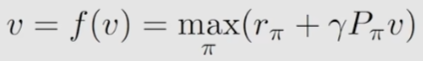

在上一个lecture中，介绍了`contration mapping theorem`，采用了迭代求解法：

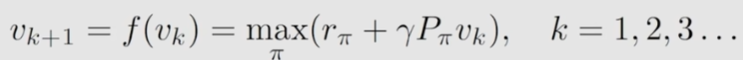

其中，$v_0$是随机给定。

实际上，这个算法就被称为`value iteration`

算法的更新包含两个步骤：

Step 1: policy update. 根据 $v_k$ ，求解 $\pi$ 

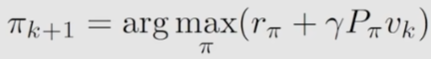 

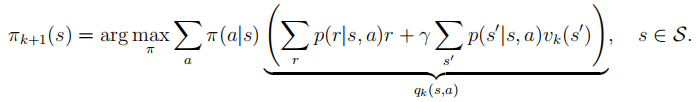

Step 2: 把步骤1中求解的 $\pi_{k+1}$ 带入下式，进行value update.

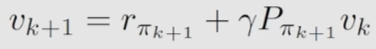

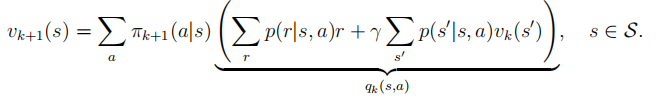

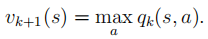

注意：更新时，$v_k$ 并不是state value，因为迭代过程中它并不满足贝尔曼方程（多次迭代后，结果逼近满足贝尔曼方程的 $v_k$ 值）

In summary, 上述过程总结如下：  

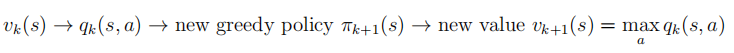

>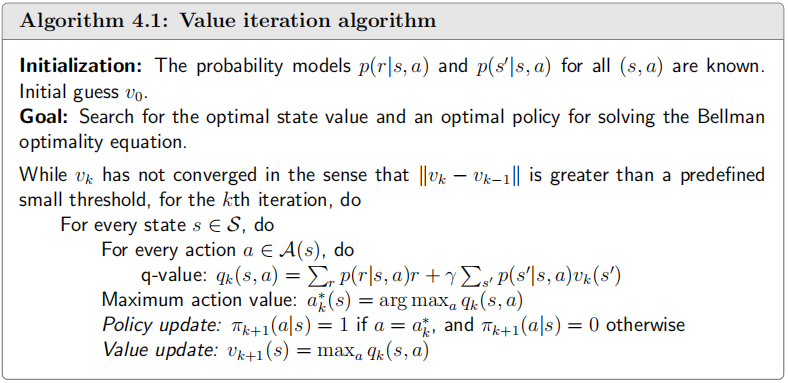